# Active learning in logistic regression
## Data example
We will work on functional magnetic resonance imaging (fMRI) data in the following exercise. The data comes from a finger-tapping experiment experiment conducted at the Danish Research Centre for Magnetic Resonance at Hvidovre Hospital. The experiment consists of 20 seconds blocks of sequential finger tapping with left or right hand separated by 9.88 seconds of rest between blocks. And contains data recorded on 29 healthy participants on a 3T Siemens Magnetom Trio MR scanner using a gradient echo planar imaging sequence with a repetition rate (inverse sampling rate) of 2.49 seconds.

In fMRI data the socalled BOLD signal is a delayed hemodynamic signal in response to brain activation. In order to produce an estimate of the expected signal change due to finger tapping for each block we here assume a linear time invariant canonical shape of the hemodynamic response function and estimate the signal amplitude in each voxel using a multiple linear regression model. The result is that the 3D dimensional array $\boldsymbol{X}$ contains individual subjects that did the task in the first dimension, samples (that is the 20 seconds activation blocks) as the second dimension, and voxels (3D brain scan unfolded as a vector) as the third dimension.

Additional preprocessing steps include normalization to a standard brain template (MNI space) and spatial smoothing by 8mm full-width at half-maximum isotropic Gaussian kernel but this is not important for the exercise.

The labels (left/right fingertapping) are provided in the array $\boldsymbol{y}$.
We will simply concatenate across subjects in the following therefore producing a matrix $\boldsymbol{X}$ and a vector $\boldsymbol{y}$.

The idea is to do socalled brain decoding (or what might be referred to as mind reading in the more popular literature) where we in this simple setting attempt to determine if subjects finger tapped with either left or right hand in each block.
You likely have to be a little patient when downloading the data, as the file is around 400MB. It is also availible on DTU Inside just in case.

In [74]:
#Preliminaries
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import urllib.request
import os, sys
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.datasets import make_friedman2

N = 10000
X = np.random.rand(N,6)
print(X.shape)
y = np.random.randint(2, size = N)

(10000, 6)


The problem is quite high dimensional as each brain volume consists of 173.628 voxels of 2mm isotropic resolution. In the following we will initially consider a simple linear regression model for this purpose, however most of this would immediately generalize to other models such as the SVC and linear discriminant analysis. The idea is to consider pool based sampling as an active learning scenario.
We want the model to generalize across subjects and therefore reserve a test set using the last 15 participants, and consider the remaining 14 samples as part of an unlabeled pool.

In [75]:
#divide up into training pool for pool based active learnng
#husk at indsætte np.concatenate med rigtig data, se den originale notebook
Xtest=X[:int(0.8*N)]
ytest=y[:int(0.8*N)]
Xpool=X[int(0.8*N):]
ypool=y[int(0.8*N):]

We then define a Logistic regression model using sklearn and investigate how performance change when gradually increasing the training set randomly from 10 to 58 samples (here in steps of 2 such that this does not take too long).

In [76]:
gp = GaussianProcessClassifier()

np.random.seed(42) # random seed to ensure same results but feel free to change
addn=2 #samples to add each time
#randomize order of pool to avoid sampling the same subject sequentially
order=np.random.permutation(range(len(ypool)))

In [77]:
#samples in the pool
poolidx=np.arange(len(Xpool),dtype=np.int)
ninit = 10 #initial samples
#initial training set
trainset=order[:ninit]
print(order)
print(trainset)
Xtrain=np.take(Xpool,trainset,axis=0)
ytrain=np.take(ypool,trainset,axis=0)
#remove data from pool
poolidx=np.setdiff1d(poolidx,trainset)

model=gp
testacc=[]
for i in range(25):
    model.fit(np.take(Xpool,order[:ninit+i*addn],axis=0),np.take(ypool,order[:ninit+i*addn],axis=0))
    ye=model.predict(Xtest)
    testacc.append((ninit+i*addn,sklearn.metrics.accuracy_score(ytest,ye)))
    print('Model: GP, %i random samples'%(ninit+i*addn))

[1860  353 1333 ...  860 1459 1126]
[1860  353 1333  905 1289 1273  938 1731   65 1323]
Model: GP, 10 random samples
Model: GP, 12 random samples
Model: GP, 14 random samples
Model: GP, 16 random samples
Model: GP, 18 random samples
Model: GP, 20 random samples
Model: GP, 22 random samples
Model: GP, 24 random samples
Model: GP, 26 random samples
Model: GP, 28 random samples
Model: GP, 30 random samples
Model: GP, 32 random samples
Model: GP, 34 random samples
Model: GP, 36 random samples
Model: GP, 38 random samples
Model: GP, 40 random samples
Model: GP, 42 random samples
Model: GP, 44 random samples
Model: GP, 46 random samples
Model: GP, 48 random samples
Model: GP, 50 random samples
Model: GP, 52 random samples
Model: GP, 54 random samples
Model: GP, 56 random samples
Model: GP, 58 random samples


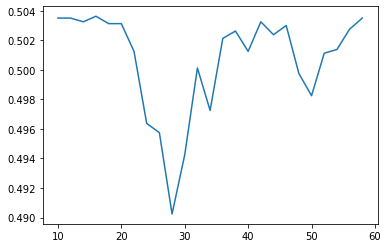

In [79]:
#Plot learning curve
plt.plot(*tuple(np.array(testacc).T));

# Uncertainty sampling
In the following grow the training set by uncertainty sampling from the pool. For the logistic regression model you can get label probabilities using the .predict_proba method and manually calculate your preferred uncertainty metric (least confident, minimum margin, entropy).

<font color=blue> 1. Is active learning outperforming random sampling in this setting?<br>
    <font color=green>Yes, the performance of active learning appear to be consistently outperforming random sampling, note that the classification task is rather easy here as the performance is already high given only few samples.<br>
<font color=blue> 2. Will it make a difference which one of the three metrics you use here?<br>
    <font color=green> No, as this is binary classification the three metrics (least confident, margin and entropy) will lead to the same sample being acquired (the one nearest p=0.5) the two first are obviously equivalent, and as log is a monitonic function, we can explicitly see this by equating the derivative of the entropy to zero, as shown below using sympy.

In [80]:
import sympy
px=sympy.Symbol('p(x)')
E=px*sympy.log(px)+(1-px)*sympy.log(1-px)
print('E=%s'%E)
dE=sympy.diff(E,px)
print('dE/dp(x)=%s'%dE)
px_opt=sympy.solve(dE,px)
print(r'p_{opt}(x)=%s'%px_opt)

E=p(x)*log(p(x)) + (1 - p(x))*log(1 - p(x))
dE/dp(x)=log(p(x)) - log(1 - p(x))
p_{opt}(x)=[1/2]


In [81]:
    testacc_al=[]
    trainset=order[:ninit]
    Xtrain=np.take(Xpool,trainset,axis=0)
    ytrain=np.take(ypool,trainset,axis=0)
    poolidx=np.arange(len(Xpool),dtype=np.int)
    poolidx=np.setdiff1d(poolidx,trainset)
    for i in range(25):
        model.fit(Xtrain,ytrain)
        ye=model.predict(Xtest)
        testacc_al.append((len(Xtrain),sklearn.metrics.accuracy_score(ytest,ye)))
        ypool_p = model.predict_proba(Xpool[poolidx])
        ypool_p_sort_idx = np.argsort(-ypool_p.max(1)) #least confident 
        Xtrain=np.concatenate((Xtrain,Xpool[poolidx[ypool_p_sort_idx[-addn:]]]))
        ytrain=np.concatenate((ytrain,ypool[poolidx[ypool_p_sort_idx[-addn:]]]))
        poolidx=np.setdiff1d(poolidx,ypool_p_sort_idx[-addn:])
        print('Model: GP, %i samples (uncertainty sampling)'%(len(Xtrain)))

Model: GP, 12 samples (uncertainty sampling)
Model: GP, 14 samples (uncertainty sampling)
Model: GP, 16 samples (uncertainty sampling)
Model: GP, 18 samples (uncertainty sampling)
Model: GP, 20 samples (uncertainty sampling)
Model: GP, 22 samples (uncertainty sampling)
Model: GP, 24 samples (uncertainty sampling)
Model: GP, 26 samples (uncertainty sampling)
Model: GP, 28 samples (uncertainty sampling)
Model: GP, 30 samples (uncertainty sampling)
Model: GP, 32 samples (uncertainty sampling)
Model: GP, 34 samples (uncertainty sampling)
Model: GP, 36 samples (uncertainty sampling)
Model: GP, 38 samples (uncertainty sampling)
Model: GP, 40 samples (uncertainty sampling)
Model: GP, 42 samples (uncertainty sampling)
Model: GP, 44 samples (uncertainty sampling)
Model: GP, 46 samples (uncertainty sampling)
Model: GP, 48 samples (uncertainty sampling)
Model: GP, 50 samples (uncertainty sampling)
Model: GP, 52 samples (uncertainty sampling)
Model: GP, 54 samples (uncertainty sampling)
Model: GP,

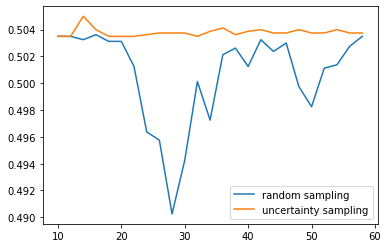

In [82]:
#Plot learning curve
plt.plot(*tuple(np.array(testacc).T));
plt.plot(*tuple(np.array(testacc_al).T));
plt.legend(('random sampling','uncertainty sampling'));

# Query by commitee
Direct uncertainty sampling is only feasible for models that can provide realistic uncertainty estimates. As an alternative we can consider query by committee (QBC).

In the following train a committee of logistic regression models using bootstrapping (sampling with replacement). For this the function sklearn.util.resample, using stratify=ytrain as an option here will ensure that you don't end up with bootstrap samples with only one label.

The number of member models in the committee is a free parameters which will greatly affect the computational complexity, here something like 10 members should be sufficient. 

In [83]:
testacc_qbc=[]
ncomm=10
trainset=order[:ninit]
Xtrain=np.take(Xpool,trainset,axis=0)
ytrain=np.take(ypool,trainset,axis=0)
poolidx=np.arange(len(Xpool),dtype=np.int)
poolidx=np.setdiff1d(poolidx,trainset)
for i in range(25):
    ypool_lab=[]
    for k in range(ncomm):
        Xtr,ytr=sklearn.utils.resample(Xtrain,ytrain,stratify=ytrain)
        model.fit(Xtr, ytr)
        ypool_lab.append(model.predict(Xpool[poolidx]))
    ypool_p=(np.mean(np.array(ypool_lab)==1,0),np.mean(np.array(ypool_lab)==2,0))
    ypool_p=np.array(ypool_p).T
    model.fit(Xtrain,ytrain)
    ye=model.predict(Xtest)
    testacc_qbc.append((len(Xtrain),sklearn.metrics.accuracy_score(ytest,ye)))


    ypool_p_sort_idx = np.argsort(ypool_p.min(1)) #least confident
    Xtrain=np.concatenate((Xtrain,Xpool[poolidx[ypool_p_sort_idx[-addn:]]]))
    ytrain=np.concatenate((ytrain,ypool[poolidx[ypool_p_sort_idx[-addn:]]]))
    poolidx=np.setdiff1d(poolidx,ypool_p_sort_idx[-addn:])
    print('Model: GP, %i samples (QBC)'%(ninit+i*addn))


Model: GP, 10 samples (QBC)
Model: GP, 12 samples (QBC)
Model: GP, 14 samples (QBC)
Model: GP, 16 samples (QBC)
Model: GP, 18 samples (QBC)
Model: GP, 20 samples (QBC)
Model: GP, 22 samples (QBC)
Model: GP, 24 samples (QBC)
Model: GP, 26 samples (QBC)
Model: GP, 28 samples (QBC)
Model: GP, 30 samples (QBC)
Model: GP, 32 samples (QBC)
Model: GP, 34 samples (QBC)
Model: GP, 36 samples (QBC)
Model: GP, 38 samples (QBC)
Model: GP, 40 samples (QBC)
Model: GP, 42 samples (QBC)
Model: GP, 44 samples (QBC)
Model: GP, 46 samples (QBC)
Model: GP, 48 samples (QBC)
Model: GP, 50 samples (QBC)
Model: GP, 52 samples (QBC)
Model: GP, 54 samples (QBC)
Model: GP, 56 samples (QBC)
Model: GP, 58 samples (QBC)


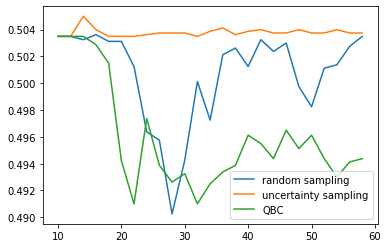

In [84]:
#Plot learning curve
plt.plot(*tuple(np.array(testacc).T));
plt.plot(*tuple(np.array(testacc_al).T));
plt.plot(*tuple(np.array(testacc_qbc).T));
plt.legend(('random sampling','uncertainty sampling','QBC'));

# Expected model change
As a last alternative we will consider expected improvement estimated according to the size of the gradient of the model parameters (hence focus on samples which are expected to change the model the most).

In binary logistic regression the probability of the high class (label=2 in our example) is given by $$p(\boldsymbol{\hat x}|\hat y=2)=\frac{1}{1+\operatorname{exp}(-\boldsymbol\theta^\top \boldsymbol{\hat{x}})},$$
where $\boldsymbol{\hat x}$ is a new candidate sample from the unlabeled pool. Equivalently for the low class:
$$p(\boldsymbol{\hat x}|\hat y=1)=1-\frac{1}{1+\operatorname{exp}(-\boldsymbol\theta^\top \boldsymbol{\hat{x}})}=\frac{\operatorname{exp}(-\boldsymbol\theta^\top \boldsymbol{\hat{x}})}{1+\operatorname{exp}(-\boldsymbol\theta^\top \boldsymbol{\hat{x}})}.$$

Hence, the loss function then becomes:
$$\mathcal L(\boldsymbol{\hat x}|\hat y=2)=-\operatorname{log}(p(\boldsymbol{\hat x}|\hat y=2))=\operatorname{log}(1+\operatorname{exp}(-\boldsymbol\theta^\top \boldsymbol{\hat{x}})),$$ and
$$\mathcal L(\boldsymbol{\hat x}|\hat y=1)=-\operatorname{log}(p(\boldsymbol{\hat x}|\hat y=2))=\operatorname{log}(1+\operatorname{exp}(\boldsymbol\theta^\top \boldsymbol{\hat{x}})).$$


We now differentiate with respect to the parameters for each of these cases to obtain (you could of course also do this with automatic differentiation in pytorch, but for sake of example we do it analytically here, there are few basic manipulations of exponentials needed here to get this compact notation (note that the minus in $\operatorname{exp}(-\theta_i x_i)$ disappeared):
$$\frac{\delta \mathcal L(\boldsymbol{\hat x}|\hat y=2)}{\delta \theta_i}=\frac{- {\hat x_i}}{1+\operatorname{exp}(\theta_i {\hat{x_i}})},$$ and 
$$\frac{\delta \mathcal L(\boldsymbol{\hat x}|\hat y=1)}{\delta \theta_i}=\frac{{\hat x_i} \operatorname{exp}(\theta {\hat{x_i}})}{1+\operatorname{exp}(\theta_i {\hat{x_i}})}.$$

As we actually use the l2 penalized logistic regression here the complete cost function actually contains an additional shrinkage term $1/(2C) ||\theta||^2$. The complete derivatives are actually as follows:

$$\frac{\delta \mathcal{\tilde{L}}(\boldsymbol{\hat x}|\hat y=2)}{\delta \theta_i}=\frac{- {\hat x_i}}{1+\operatorname{exp}(\theta_i {\hat{x_i}})}+\theta_i/C,$$ and 
$$\frac{\delta \mathcal{\tilde{L}}(\boldsymbol{\hat x}|\hat y=1)}{\delta \theta_i}=\frac{{\hat x_i} \operatorname{exp}(\theta {\hat{x_i}})}{1+\operatorname{exp}(\theta_i {\hat{x_i}})}+\theta_i/C.$$


From this calculate the euclidean norm of the gradient and weight according to $p(\boldsymbol{\hat x})$. In accordance with the description in the notes the gradient of the points within the training set are close to zero as the model has converged to samples the training set, therefore we only need to evaluate this for each candidate point individually.

In our model is severely overparametrized as there are many features (voxels) out of which most are actually not relevant for classification. Therefore, this metric might not work well as the gradient will likely be dominated by unimportant voxels.
In such cases regularization can be important as well as preprocessing measures to ensure that features are appropriately normalized, which we did not consider in this exercise.

<font color=blue>Now use this expected improvement metric to suggest new samples from the pool,
and visualize the training curve.


In [37]:
testacc_emc=[]
trainset=order[:ninit]
Xtrain=np.take(Xpool,trainset,axis=0)
ytrain=np.take(ypool,trainset,axis=0)
poolidx=np.arange(len(Xpool),dtype=np.int)
poolidx=np.setdiff1d(poolidx,trainset)

def norm_grad_x(theta,x,C=1.):
    #probability of high class
  p1 = 1/(1+np.exp(-np.sum(theta*x)))
    #probability of low class
  p0 = 1-p1
    #derivative of cost as derived above for high class
  dL1=-x/(1+np.exp(theta*x))+theta/C
    #same for low class
  dL0=x*np.exp(theta*x)/(1+np.exp(theta*x))+theta/C
    #2-norm of these
  g1=np.sqrt(np.sum(dL1**2,1))
  g0=np.sqrt(np.sum(dL0**2,1))
    #averaged according to probabilities
  emc=p1*g1+p0*g0
  return emc

In [38]:
for i in range(25):
    ypool_lab=[]
    model.fit(Xtrain,ytrain)
    emc=norm_grad_x(model.coef_, Xpool[poolidx])
    ye=model.predict(Xtest)
    testacc_emc.append((len(Xtrain),sklearn.metrics.accuracy_score(ytest,ye)))


    ypool_p_sort_idx = np.argsort(emc)
    Xtrain=np.concatenate((Xtrain,Xpool[poolidx[ypool_p_sort_idx[-addn:]]]))
    ytrain=np.concatenate((ytrain,ypool[poolidx[ypool_p_sort_idx[-addn:]]]))
    poolidx=np.setdiff1d(poolidx,ypool_p_sort_idx[-addn:])
    print('Model: GP, %i samples (EMC)'%(ninit+i*addn))


Model: LR, 10 samples (EMC)
Model: LR, 12 samples (EMC)
Model: LR, 14 samples (EMC)
Model: LR, 16 samples (EMC)
Model: LR, 18 samples (EMC)
Model: LR, 20 samples (EMC)
Model: LR, 22 samples (EMC)
Model: LR, 24 samples (EMC)
Model: LR, 26 samples (EMC)
Model: LR, 28 samples (EMC)
Model: LR, 30 samples (EMC)
Model: LR, 32 samples (EMC)
Model: LR, 34 samples (EMC)
Model: LR, 36 samples (EMC)
Model: LR, 38 samples (EMC)
Model: LR, 40 samples (EMC)
Model: LR, 42 samples (EMC)
Model: LR, 44 samples (EMC)
Model: LR, 46 samples (EMC)
Model: LR, 48 samples (EMC)
Model: LR, 50 samples (EMC)
Model: LR, 52 samples (EMC)
Model: LR, 54 samples (EMC)
Model: LR, 56 samples (EMC)
Model: LR, 58 samples (EMC)


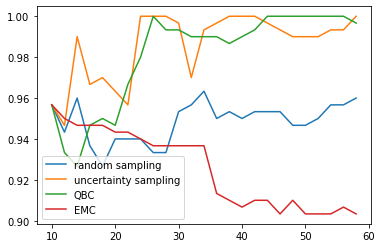

In [39]:
#Plot learning curve
plt.plot(*tuple(np.array(testacc).T));
plt.plot(*tuple(np.array(testacc_al).T));
plt.plot(*tuple(np.array(testacc_qbc).T));
plt.plot(*tuple(np.array(testacc_emc).T));
plt.legend(('random sampling','uncertainty sampling','QBC','EMC'));


<font color=green> Here we see that the expected model change/impact is not doing a very good job here as already hinted above this is likely because the number of model parameters (weights) is very high and therefore the gradient will likely be dominated by unimportant voxels even if they have low weigth in the model.  